### 개선방향
- `04_03_FE_means.ipynb`에서 전처리를 완료한 데이터를 사용하여 LightGBM을 학습
- 규제 관련 하이퍼 파라미터를 최소한으로 조정

# Module

In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from lightgbm.callback import early_stopping, log_evaluation
import optuna
from optuna.integration import LightGBMPruningCallback
from optuna.samplers import TPESampler
from optuna.visualization.matplotlib import plot_optimization_history, plot_param_importances

# Data

In [2]:
data_path = "./data/"

all_data = joblib.load(data_path + 'all_data2.joblib')
sub = pd.read_csv(data_path + 'sample_submission.csv')

In [3]:
all_data.shape

(8812244, 57)

In [4]:
all_data = all_data.drop(columns='item_id')

# Model

## prepare

In [5]:
x_train = all_data[all_data['date_block_num'] < 33]
x_train = x_train.drop(['item_cnt_month'], axis=1)

x_val = all_data[all_data['date_block_num'] == 33]
x_val = x_val.drop(['item_cnt_month'], axis=1)

x_test = all_data[all_data['date_block_num'] == 34]
x_test = x_test.drop(['item_cnt_month'], axis=1)

y_train = all_data[all_data['date_block_num'] < 33]['item_cnt_month']
y_val = all_data[all_data['date_block_num'] == 33]['item_cnt_month']

x_all = pd.concat([x_train, x_val])
y_all = pd.concat([y_train, y_val])

x_sample = all_data[(all_data['date_block_num'] > 12)&(all_data['date_block_num'] < 33)]
x_sample = x_sample.drop(['item_cnt_month'], axis=1)
y_sample = all_data[(all_data['date_block_num'] > 12)&(all_data['date_block_num'] < 33)]['item_cnt_month']

del all_data

In [6]:
x_sample.shape, y_sample.shape

((4755902, 55), (4755902,))

In [7]:
cat_features = ['shop_id', 'type', 'subtype', 'shop_type', 'shop_category', 'item_category_id', 'city', 'month']

dtrain = lgb.Dataset(x_sample, y_sample, categorical_feature=cat_features)
dval = lgb.Dataset(x_val, y_val, categorical_feature=cat_features, reference=dtrain)

- 하이퍼 파라미터 최적화 과정에서 일부 데이터만 활용

## optuna

In [8]:
%%time

fixed_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'force_col_wise': True,
    'random_state': 2025,
    'verbosity': -1,
    'feature_pre_filter': False,
    'reg_alpha': 0.01,
    'reg_lambda': 0.01,
}

def objective_lgbm(trial):
    params = {
        **fixed_params,
        'num_leaves': trial.suggest_int('num_leaves', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.05, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 40),
    }
    
    pruning_callback = LightGBMPruningCallback(trial, 'rmse', valid_name='eval')
    
    lgb_model = lgb.train(
        params=params,
        train_set=dtrain,
        num_boost_round=1500,
        valid_sets=[dval],
        valid_names=['eval'],
        callbacks=[
            early_stopping(stopping_rounds=300, verbose=False),
            log_evaluation(period=0),
            pruning_callback
        ]
    )
    
    trial.set_user_attr("best_iter", lgb_model.best_iteration)
    
    preds = lgb_model.predict(x_val, num_iteration=lgb_model.best_iteration)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    return rmse 


sampler = TPESampler(seed=2025)
study_lgbm = optuna.create_study(direction='minimize', sampler=sampler)
study_lgbm.optimize(objective_lgbm, n_trials=30, show_progress_bar=True)

[I 2025-12-03 09:34:36,049] A new study created in memory with name: no-name-3d394c33-c3ab-4326-b486-c63b4c9cb32d


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-12-03 09:37:51,498] Trial 0 finished with value: 0.7821519299872148 and parameters: {'num_leaves': 154, 'learning_rate': 0.03862083925763863, 'feature_fraction': 0.9663028199432513, 'bagging_fraction': 0.7227840820237976, 'bagging_freq': 4, 'min_child_samples': 17}. Best is trial 0 with value: 0.7821519299872148.
[I 2025-12-03 09:48:35,479] Trial 1 finished with value: 0.7777785416962028 and parameters: {'num_leaves': 363, 'learning_rate': 0.015544864538066484, 'feature_fraction': 0.9821192096250286, 'bagging_fraction': 0.90049223743472, 'bagging_freq': 5, 'min_child_samples': 34}. Best is trial 1 with value: 0.7777785416962028.
[I 2025-12-03 09:52:10,169] Trial 2 finished with value: 0.7766770729359123 and parameters: {'num_leaves': 116, 'learning_rate': 0.02940545313845548, 'feature_fraction': 0.5015855583776472, 'bagging_fraction': 0.6464046960247385, 'bagging_freq': 7, 'min_child_samples': 38}. Best is trial 2 with value: 0.7766770729359123.
[I 2025-12-03 10:03:17,418] Tria

In [9]:
print(f'Total Trials : {len(study_lgbm.trials)}')
print(f'Best Trial : {study_lgbm.best_trial.number}')
print(f'Best Iteration : {study_lgbm.best_trial.user_attrs['best_iter']}')
print(f'Best Score : {study_lgbm.best_value:.5f}')
print('=='*20,'Best Parameters', '=='*20)
for key, value in study_lgbm.best_params.items():
    print(f'{key} : {value}')

Total Trials : 30
Best Trial : 7
Best Iteration : 338
Best Score : 0.77435
======================================== Best Parameters ========================================
num_leaves : 421
learning_rate : 0.039404889885955884
feature_fraction : 0.7410645376172664
bagging_fraction : 0.923964951174064
bagging_freq : 3
min_child_samples : 20


/tmp/ipykernel_18012/1748665859.py:1: ExperimentalWarning: optuna.visualization.matplotlib._optimization_history.plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study_lgbm)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

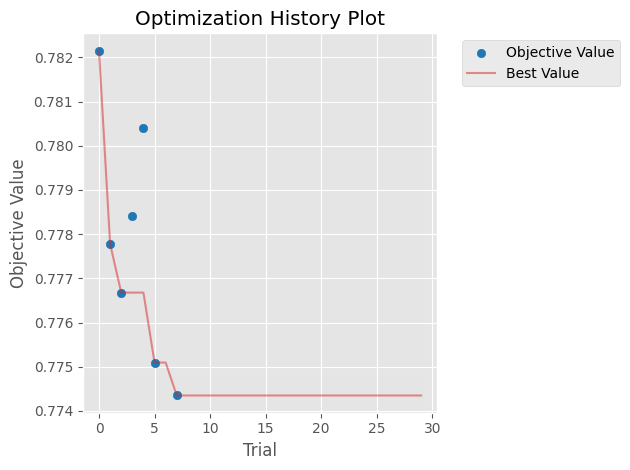

In [10]:
plot_optimization_history(study_lgbm)

/tmp/ipykernel_18012/3004270277.py:1: ExperimentalWarning: optuna.visualization.matplotlib._param_importances.plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study_lgbm)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

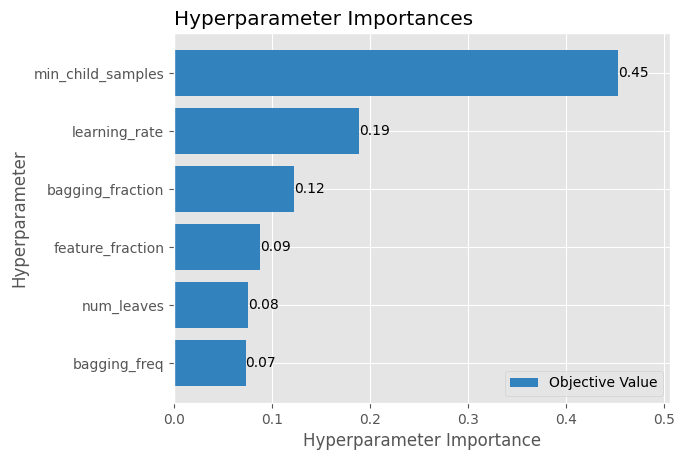

In [11]:
plot_param_importances(study_lgbm)

## train

In [12]:
best_params = study_lgbm.best_params
best_params.update(fixed_params)
best_iter = study_lgbm.best_trial.user_attrs['best_iter']

In [13]:
dtrain_all = lgb.Dataset(x_all, y_all, categorical_feature=cat_features)
final_iter = int(best_iter * 1.3)

In [14]:
%%time

final_lgbm_model = lgb.train(
    params=best_params,
    train_set=dtrain_all,
    num_boost_round=final_iter,
    valid_sets=[dtrain_all],
    callbacks=[
        log_evaluation(period=100)
    ]
)

[100]	training's rmse: 0.820154
[200]	training's rmse: 0.790204
[300]	training's rmse: 0.774376
[400]	training's rmse: 0.762618
CPU times: user 24min 13s, sys: 6.45 s, total: 24min 19s
Wall time: 6min 27s


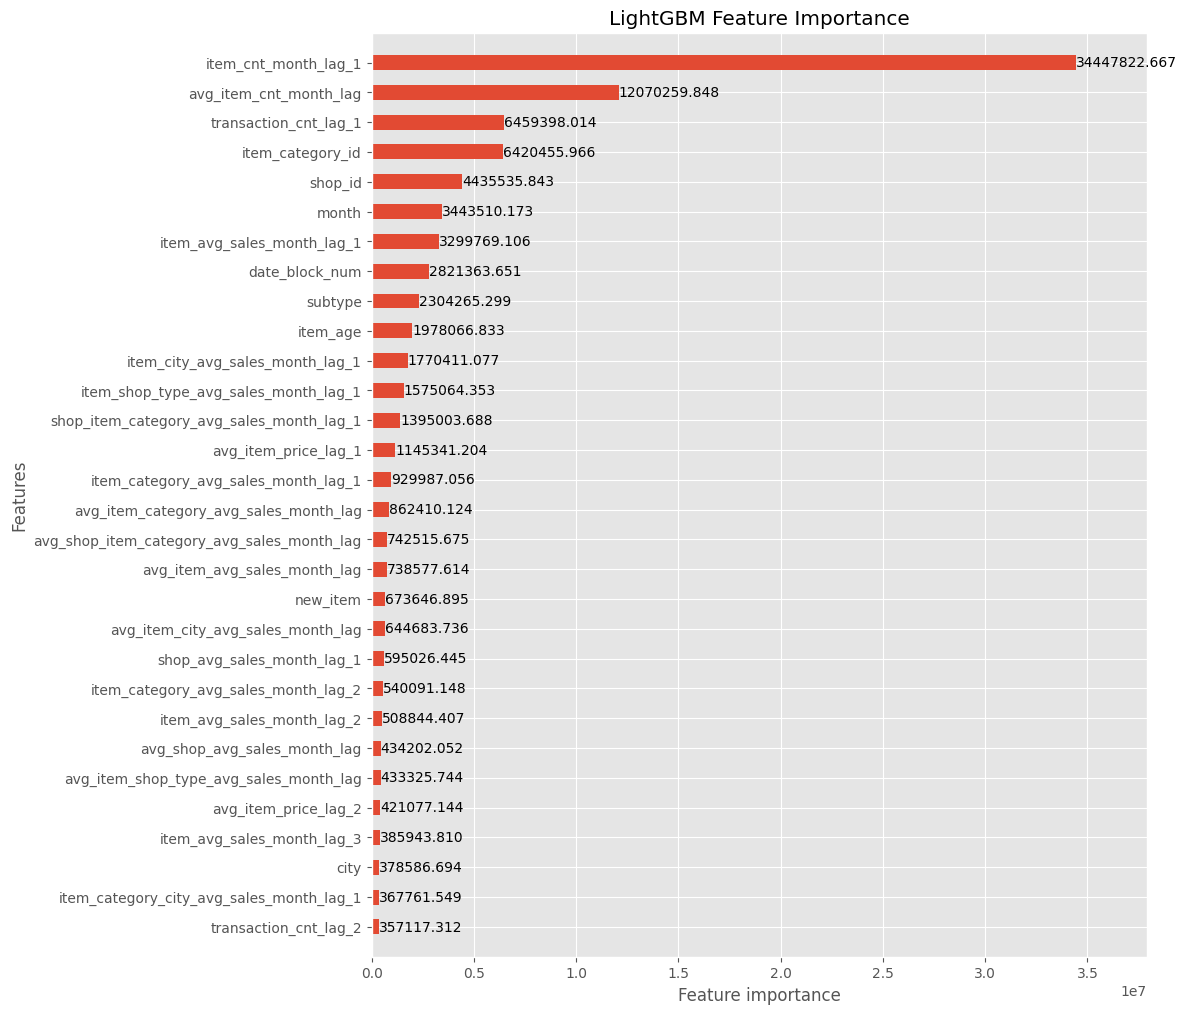

In [15]:
plt.figure(figsize=(10, 12)) 
lgb.plot_importance(final_lgbm_model, max_num_features=30, height=0.5, ax=plt.gca(), importance_type='gain')
plt.title('LightGBM Feature Importance')
plt.show()

In [16]:
final_lgbm_model.save_model(data_path + '05_04_lgbm_model.txt')

## prediction

In [17]:
final_lgbm_model = lgb.Booster(model_file='./data/05_04_lgbm_model.txt')

In [18]:
predictions = final_lgbm_model.predict(x_test).clip(0, 20)
sub['item_cnt_month'] = predictions
sub.head()

,ID,item_cnt_month
0,0,0.634874
1,1,0.315559
2,2,0.860072
3,3,0.553170
4,4,3.523678


In [19]:
print(pd.Series(predictions).describe())

count    214200.000000
mean          0.299320
std           0.877459
min           0.000000
25%           0.016901
50%           0.074938
75%           0.248027
max          20.000000
dtype: float64


In [20]:
sub.to_csv(data_path + '05_04_submssion_lgbm_model.csv', index=False)

In [21]:
!chmod 600 /teamspace/studios/this_studio/.kaggle/kaggle.json
!kaggle competitions submit -c competitive-data-science-predict-future-sales -f "./data/05_04_submssion_lgbm_model.csv" -m "05_04_submssion_lgbm_model"

100%|██████████████████████████████████████| 5.18M/5.18M [00:00<00:00, 11.3MB/s]
Successfully submitted to Predict Future Sales

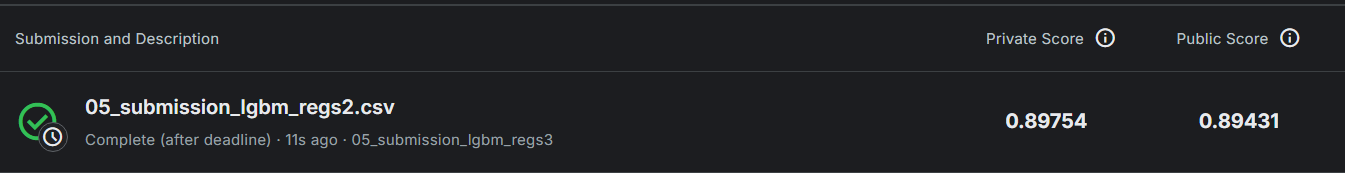